<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture Series by Dr. Adrian Oeftiger</h2>

<h3 style="text-align: center; vertical-align: middle; margin-top: 1em; margin-bottom: 1em;">Guest Lecture by Dr. Andrea Santamaria Garcia and Chenran Xu</h3>

<div style="width: 45%; margin: auto; vertical-align: middle; ">
<img src="./img/etit.png" style="width: 40%; float: left; vertical-align: center" /><img src="./img/KIT_logo.svg" style="width: 38%; float: right; vertical-align: center;" />
</div>
<div style="clear: both; vertical-align: middle;"></div>

<h3 style="text-align: center; vertical-align: middle; ">Part 14: 10.02.2023</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-14/v1.0"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-14/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-14).

<h2>Run this first!</h2>

Imports and modules:

In [122]:
from config import *
from importlib import reload
import time
import config
%matplotlib inline

In [123]:
reload(config)

<module 'config' from '/home/ws/zx5016/Repositories/github/TUDa-NMAP-14/config.py'>

<h2 style="color: #b51f2a">Preparation</h2>

- <a href="https://moodle.tu-darmstadt.de/mod/lti/view.php?id=1101645">Introduction to machine learning applied to particle accelerators</a> by Dr. Andrea Santamaria Garcia
- <a href="https://moodle.tu-darmstadt.de/mod/lti/view.php?id=1101645">Machine learning activities at the accelerators of KIT</a> by Dr. Andrea Santamaria Garcia
- <a href="https://moodle.tu-darmstadt.de/mod/lti/view.php?id=1101645">Introduction to Bayesian optimization</a> by Chenran Xu

<h2 style="color: #b51f2a">Today!</h2>

In this tutorial notebook we will implement all the basic components of **Bayesian optimization (BO)** to find the global maximum of an unknown function, and see an example applied to accelerators.

- <a href="http://localhost:8888/notebooks/lecture.ipynb#Part-I:-Bayesian-Optimization-Theory">Part I: Bayesian Optimization Theory</a>
- <a href="http://localhost:8888/notebooks/lecture.ipynb#Part-II:-Bayesian-Optimization-Algorithm-Implementation">Part II: Bayesian Optimization Algorithm implementation</a>
- <a href="http://localhost:8888/notebooks/lecture.ipynb#Part-III:-Bayesian-Optimization-for-Beam-Positioning-and-Focusing-in-a-Linac">Part III: Bayesian Optimization for Beam Positioning and Focusing in a Linac</a>

<h2 style="color: #b51f2a">Abbreviations used in this notebook</h2>

- **BO**: Bayesian optimization
- **GP**: Gaussian process

<h2 style="color: #b51f2a">Jargon</h2>

These terms are used interchangeably:

- __Objective, metric, target function__: $f(x)$ an unknown (black-box) function, for which the value is to be optimized (here: maximization)
- __Observation, function evaluation, function query, data point__: $y=f(x)$, the value of function $f$ at a particular value of $x$
- __Feature, tuning parameter, "knob", dimension, actuator__: $x_i = x_0, x_1, ...$, dimensions of your problem, correlated parameters the algorithm will vary
- __Search space, bounds, optimization range__: a (continuous) parameter space where the input parameters are allowed to be varied in the optimization

<div style="text-align: center; width:100%;">
    <h2>Part I: Bayesian Optimization Theory</h2>
</div>

<h2>Bayes' Theorem</h2>

Bayes' theorem is used for __statistical inference__, i.e. the process of using data analysis to infer properties of an underlying distribution of probability, or in other words, the process of drawing conclusions from data subject to random variations. The Bayes' theorem reads:
    
<img src="img/bayes.png" style="width:50%; margin:auto;"/>
<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">image from <a href="https://www.freecodecamp.org/news/bayes-rule-explained/">Bayes' Rule – Explained For Beginners</a></p>

- $A, B$ are events, where $A$ can be interpreted as our hypothesis and $B$ as getting evidence
- $P(A|B)$ is the <span style='color:#b51f2a'>**posterior probability**</span> of event $A$ happening given that event $B$ is observed, or the probability that the hypothesis is true given the evidence.
- $P(B|A)$ is the <span style='color:#b51f2a'>**likelihood probability**</span> the conditional probablity of observing $B$ given $A$, or the probability of seeing the evidence if the hypothesis is true.
- $P(A), P(B)$ are the <span style='color:#b51f2a'>**independent probabilities**</span> of observing $A$ and $B$, where:
    - $P(A)$ is know as the <span style='color:#b51f2a'>**prior probability**</span>, or probability that a hypothesis is true before any evidence (observation) is present
    - $P(B)$ as the <span style='color:#b51f2a'>**marginal probability**</span>, or probability of observing the evidence

<h2>Bayes' Theorem</h2>
    
Usually when we apply Bayesian optimization to a problem of our choice we make sure that when we query $f(x)$ we always get an observation $y$ back, so the probability of getting new samples is always 100%, i.e., $P(B) = 1$

Thus the Bayes' theorem reads
    $$P(A|B) \propto P(B|A) P(A),$$
    
i.e. the __posterior probability__ is proportional to the __prior__ times the __likelihood__ probabilities.

<h3>Why use it?</h3>

Bayesian inference links the degree of belief in a hypothesis before and after accounting for evidence (observations), so it's ideal for building a probabilistic model and updating it sequentially as new data is gathered:

<img src="img/bayes_2.png" style="width:70%; margin:auto;" />
<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">image from <a href="https://www.gaussianwaves.com/2021/04/bayes-theorem/">Bayes’ theorem</a></p>

<h2>Bayesian Optimization</h2>

__Bayesian optimization (BO)__ is a sequential algorithm to globally optimize an unknown function $f(x)$. In other words, it solves problems of the form

$$\text{max}_{x \in N} f(x),$$

where $N$ is a set of observations.

The steps taken by a BO algorithm are the following:

- Bayesian optimization treats $f(x)$ as a __random function__ and places a <span style='color:#b51f2a'>__prior__</span> over it. The prior might contain previous observations (informed prior) or no information at all. These probability distributions are drawn from a probabilistic model like <span style='color:#b51f2a'>__Gaussian Processes__</span> (more information <a href="http://localhost:8892/notebooks/lecture.ipynb#Gaussian-Process-(GP)">here</a>).
- We gather new observations (getting the value of $f(x)$ at particular $x$ points).
- The <span style='color:#b51f2a'>__posterior__</span> distribution is obtained by applying Bayes' theorem.
- The <span style='color:#b51f2a'>__posterior__</span> distribution is used to build an <span style='color:#b51f2a'>__acquisition function__</span> that determines the next query point (more information <a href="http://localhost:8892/notebooks/lecture.ipynb#Acquisition-function)">here</a>).

<h2>Acquisition function</h2>

The __acquisition function__ $\alpha$ is:
- Built on the GP posterior, 
- Controls the behavior of optimization by balancing exploration and exploitation to minimize the number of function queries (observations). 
- For the standard verison of BO, the next sample point is chosen at $\mathrm{argmax}(\alpha)$. 
- In this tutorial we will introduce two widely used acquisition functions: the expected improvement (EI) and the upper confidence bound (UCB).

<h2>Gaussian Process (GP)</h2>
<h3>Introduction</h3>

A Gaussian Process (GP):
- is a way to construct your <span style='color:#b51f2a'>__prior__</span> and <span style='color:#b51f2a'>__posterior__</span> distributions.
- is a collection of random variables, where every linear combination of them is __normally distributed__.
- can be used as a __probablistic model__ (surrogate model) of the objective function $f(x)$.
    - one can consider it like a __function generator__, where all the functions drawn from the model will follow specific statistical properties.

A GP can be fully described by it's mean $\mu$ and covariance function $k(\cdot,\cdot)$
    $$f(x) \sim \mathcal{GP}(\mu(x), k(x,x'))$$
    
where $x$ and $x'$ are points in the input space.

_Note: in GP regression, one usually understands $x'$ as the observed points, and $x$ as the continuous variable_

<h2>Gaussian Process (GP)</h2>
<h3>Definitions</h3>

- <span style='color:#b51f2a'>__Kernel__</span> or <span style='color:#b51f2a'>__covariance function__</span> $k(\cdot,\cdot)$, is just a general name for a function $k$ of two arguments mapping a pair of inputs $x \in \mathcal{X}, x' \in \mathcal{X}$ into $\mathbb{R}$
    - is the basic building block of GPs
    - encodes the assumptions about the function we wish to learn
    - is a measure of how much to random variables (features) vary together (a measure of similarity)
- <span style='color:#b51f2a'>__Covariance matrix__</span> : given a set of points $\{x_i\}$ we can compute the covariance matrix $K$ whose entries are $K_{ij}=k(x_i, x_j)$, where $k$ is the covariance function.
- <span style='color:#b51f2a'>__Prior mean__ </span>$\mu(x)$: prior belief on the averaged objective function values, usually set to a constant if the function behavior is unknown.

- <span style='color:#b51f2a'>__Gaussian process regression (GPR)__</span>, also formerly known as _kriging_: a method to interpolate an unknown objective function.


<h2>Gaussian Process (GP)</h2>
<h3> Bonus: would an arbitrary function of input pairs $x$ and $x'$ be a valid covariance function?</h3>

<h2>Gaussian Process (GP)</h2>
<h3> Bonus: would an arbitrary function of input pairs $x$ and $x'$ be a valid covariance function?</h3>

The answer is no, as it has to be __positive semidefinite__. 

In this way the intersection of the covariance matrices for multiple features can have a global minima. More information and geometrical interpretation <a href="https://gowrishankar.info/blog/why-covariance-matrix-should-be-positive-semi-definite-tests-using-breast-cancer-dataset/">here</a>.

<h2>Gaussian Process (GP)</h2>
<h3>Hyperparameters</h3>

The characteristics of GP, or its ability to approximate the unknown function are dependent both on __the choice of the covariance function__ and the __values of the hyperparamters__. The hyperparamters are usually either choosen manually based on the physics, or obtained from the maximum likelihood fit (log-likelihood fit, maximum a posteriori fit) during the optimization.

- <span style='color:#b51f2a'>__Lengthscale__ $l$</span> : controls the scaling of different input dimensions, i.e. how fast the objective function is expected to change from observed points, how smooth the function is.
    - small lengthscale = function values can change quickly
    - large lengthscale = function changes slowly
- <span style='color:#b51f2a'>__Signal variance__ $\sigma^2$</span>: a scaling factor to be multiplied to the kernel function (explained next), it is essentially equivalent to normalizing/scaling the objective function.
    - small signal variance = functions stay close to their mean value
- <span style='color:#b51f2a'>__Noise variance__ $\sigma_\mathrm{n}^2$</span>: magnitude of the noise in the observed values, how much noise is expected to be present in the data.

<h2>Gaussian Process (GP)</h2>
<h3>Covariance functions (kernels)</h3>

Some of the commonly used kernels are listed below can be found <a href="https://en.wikipedia.org/wiki/Gaussian_process#Usual_covariance_functions">here</a>. They can also be combined to build more complex kernels representing the underlying physics of the objective function.

In this notebook we will use a scaled <span style='color:#b51f2a'>__radial basis function (RBF) kernel__</span>
$$k_{\mathrm{RBF}} (x,x') = \exp\left(-\frac{d_{x,x'}^2}{2 l^2}\right),$$

where:
- $l$ = lenghtscale
- $ d_{x,x'} := ||x - x'||^2 $ is the Euclidean distance between the two points

It is also known as squared exponential (SE). This resembles a normal Gaussian distribution. 

It is more or less _the default_ choice of kernel for GPs if one does not have a special assumption on the objective function.

<div style="text-align: center; width:100%;">
    <h2>Part II: Bayesian Optimization Algorithm Implementation</h2>
</div>

<h2>BoTorch: Bayesian Optimization in PyTorch</h2>

- <a href="https://botorch.org/">BoTorch</a> is the leading Python library to implement Bayesian optimization.
It is built on top of <a href="https://pytorch.org/">PyTorch</a>, which is an optimized tensor library for deep learning using GPUs and CPUS.
- A <span style='color:#b51f2a'> **tensor** </span> is an algebraic object that may map between different objects such as vectors, scalars, and even other tensors. It can be easily understood as a multidimensional matrix/array. 
    - These objects allow to easily carry out machine learning computations in problems with many features, weights, etc.
    - In PyTorch, a <a href="https://pytorch.org/docs/stable/tensors.html#:~:text=A%20torch.,of%20a%20single%20data%20type.">tensor</a> is a multi-dimensional matrix containing elements of a single data type.

<img src="img/tensor_2.jpeg" style="width:50%; margin:auto;" />
<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">image from <a href="https://towardsai.net/p/deep-learning/working-with-pytorch-tensors">Working with PyTorch tensors</a></p>

<h2>BoTorch: Bayesian Optimization in PyTorch</h2>

- **Accelerated computing** = when we add extra hardware to accelerate computation, like GPUs (needed in deep machine learning).
    - GPU: many "not-so-intelligent" cores that are parallelizable. They can carry out specific operations in a very efficient way, e.g. tensor cores perform very efficient sparse tensor multiplication.
- **We will be working with torch tensors in this notebook!** instead of the usual numpy arrays. This means you could execute this code on a GPU if you have access to one with a simple command `torch.device("cuda")`.

<h2>Build an objective function and create some random observations</h2>

Let's assume we want to find the global maximum of this function:

$$f(x) = \sin (2 \pi x) + \epsilon$$

Let's start by setting a random seed for reproducibility:

In [3]:
random_seed = 3
rng = torch.random.manual_seed(random_seed)

<h3>Create some observation points with noise</h3>

In [4]:
xmin, xmax = 0, 1
observations_tot = 10
noise_level = 0.2  # add some white noise to observations
observations_x = torch.rand(observations_tot, 1, generator=rng) * (xmax - xmin) + xmin
observations_y = (torch.sin(observations_x * 2 * np.pi) + 
                  torch.randn(size=observations_x.size(), generator=rng) * noise_level)

<h3>Create the objective function (200 samples)</h3>

In [83]:
samples = 200
objective_x = torch.linspace(xmin, xmax, samples).reshape(-1, 1)
objective_y = torch.sin(objective_x * 2 * np.pi)
test_X = torch.linspace(xmin, xmax, samples)

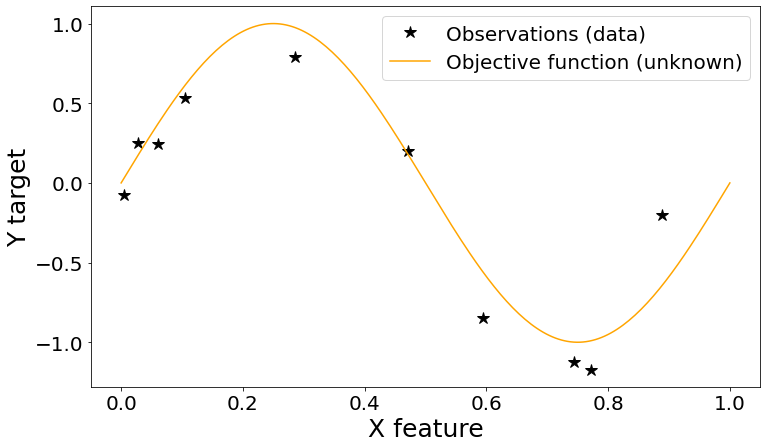

In [124]:
plt.plot(observations_x, observations_y, "*", markersize=12, color='black', label="Observations (data)")
plt.plot(objective_x, objective_y, color='orange', label="Objective function (unknown)")

plt.xlabel("X feature")
plt.ylabel("Y target")
plt.legend()

<h2>Build your first Gaussian process model</h2>


For the covariance function (kernel), we choose a scaled radial basis function (RBF) kernel
$$K_\text{Scaled-RBF} (\mathbf{x_1},\mathbf{x_2})= \theta_\text{scale} \exp\left( - \frac{1}{2}(\mathbf{x_1} - \mathbf{x_2})^\top \Sigma^{-2} (\mathbf{x_1} - \mathbf{x_2}) \right),$$

where $\theta_\text{scale}$ is the _outputscale_ parameter, $\Sigma^{2}$ is the covariance matrix; In simple case, the _lengthscales_ for each input dimension are just the diagonal terms.

c.f. [GPyTorch documentation](https://docs.gpytorch.ai/en/v1.6.0/kernels.html) for more details

<h3>Define the desired kernel, in this case RBF:</h3>

In [86]:
kernel = ScaleKernel(RBFKernel())

<h3>Build your GP model with previous observations and selected kernel:</h3>

In [8]:
model = SingleTaskGP(train_X=observations_x, train_Y=observations_y, covar_module=kernel)  

<h3>Hyperparameters</h3>

Change the hyperparameters below to the following:
- __lenghtscale__: 0.5
- __signal variance__: 0.5
- __model noise__: 0.5

In [87]:
# You can change the GP hyperparameters here
model.covar_module.base_kernel.lengthscale = 0.5
model.covar_module.outputscale = 0.5  # signal variance
model.likelihood.noise_covar.noise = 0.5

<h3>Visualization of the prior of the GP model</h3>
The GP just has a constant mean with some uncertainty.

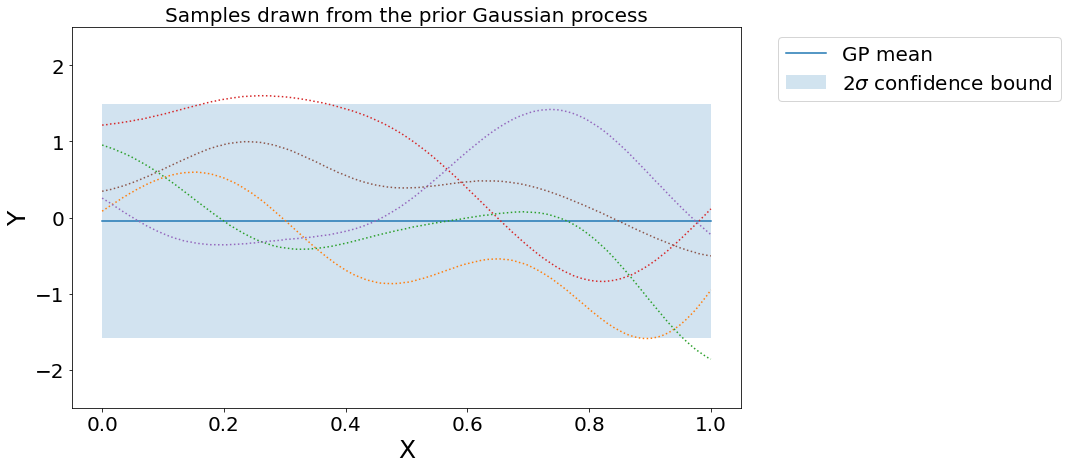

In [125]:
# Visualize the prior
ax = sample_gp_prior_plot(model, test_X)
ax.set_ylim(-2.5, 2.5);

<h3 style="color:#e6541a;">How do the hyperparameter values affect the drawn samples from the model?</h3>
<p style="color:#e6541a;">$\implies$  Change the GP hyperparameters that you set before, in the previous cells.
<p style="color:#e6541a;">$\implies$  How do you predict that the lengthscale, signal variance, and model noise will affect the shape of the samples? Test your theories</p>

<h3>Visualization of the posterior of the GP model</h3>

- With the observations we generated previously we can build the posterior distribution
- Observe the current status of our statistical model compared to our objective function

In [127]:
# You can change the GP hyperparameters here again
model.covar_module.base_kernel.lengthscale = 0.5
model.covar_module.outputscale = 0.5  # signal variance
model.likelihood.noise_covar.noise = 0.5

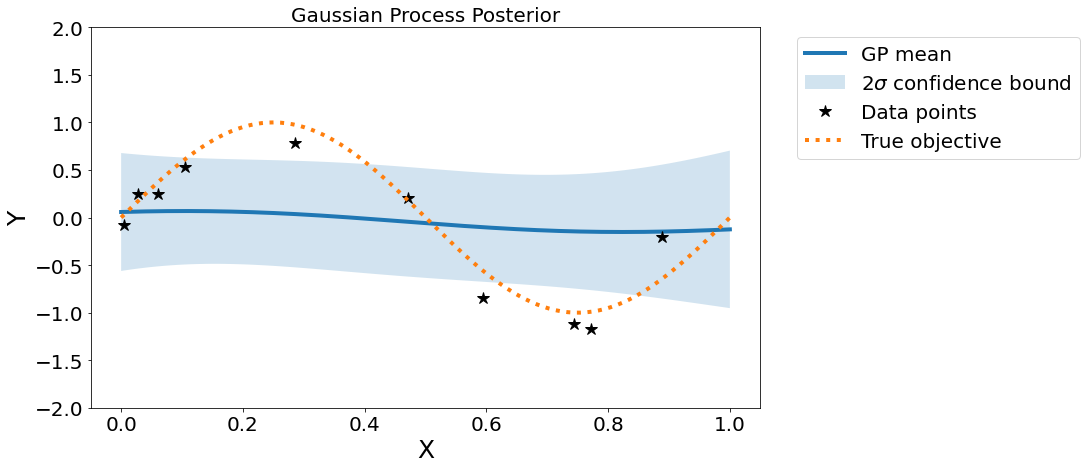

In [128]:
# Visualize the posterior
sample_gp_posterior_plot(model, test_X, y_lim=(-2,2), n_samples=0, show_true_f=True, 
                         true_f_x= objective_x, true_f_y=objective_y);

<h3 style="color:#e6541a;">Change the number of samples visualized</h3>
<p style="color:#e6541a;">$\implies$ Do this by changing the value of the <code>n_samples</code> argument in the <code>sample_gp_posterior_plot</code> function in the cell above
<p style="color:#e6541a;">$\implies$ Can you understand better how the posterior is built?

<h3 style="color:#e6541a;">Change the hyperparameters again to fit the data by hand (two cells above)</h3>
<p style="color:#e6541a;">$\implies$ Avoid under- or overfitting
<p style="color:#e6541a;">$\implies$ The GP mean should fit the data points as good as possible</p>

We will save the hyperparameters you found for comparison later:

In [129]:
manual_lenghtscale = float(model.covar_module.base_kernel.lengthscale)
manual_signal_variance = float(model.covar_module.outputscale)
manual_model_noise = float(model.likelihood.noise_covar.noise)

<h2>Guide your hyperparameter setting!</h2>

- One can use __prior knowledge__ (experience, archive data, ...) to constrain or even fix the _Gaussian process_ hyperparameters.
- Another approach is to dynamically __adapt / fit__ the hyperparameters to the data.

In BoTorch there is a convenient helper function [`fit_gpytorch_mll`](https://botorch.org/api/fit.html#botorch.fit) to fit the hyperparameters of the _Gaussian process_ model to the data using _marginal log-likelihood_ fits.

- In this approach, the hyperparameters are varied until the likelihood is maximized

In the cell below, the `ExactMarginalLogLikelihood` function takes a likelihood object as argument, which is an attribute of the model we defined before:

In [130]:
mll = ExactMarginalLogLikelihood(model.likelihood, model)

Now let's perform the fit of the hyperparameters:

In [131]:
fit_gpytorch_mll(mll);  # carries out the fit

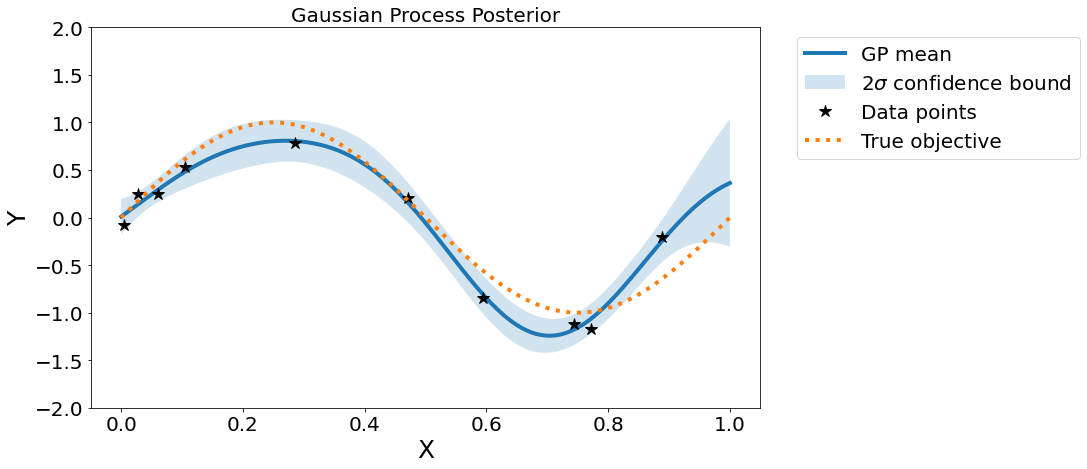

In [132]:
# Show the results
sample_gp_posterior_plot(model, test_X, y_lim=(-2,2), n_samples=0, 
                         show_true_f=True, true_f_x= objective_x, true_f_y=objective_y);

<h3 style="color:#e6541a;">Now the GP model nicely fits the data!</h3>
<p style="color:#e6541a;">$\implies$ What causes that the model is not completely following the true objective function?

<h3 style="color:#e6541a;">Let's compare manual and automatically fitted hyperparameters</h3>
<p style="color:#e6541a;">$\implies$ Execute the cell below</p>
<p style="color:#e6541a;">$\implies$ Are the values very different?</p>

In [133]:
print('Manual hyperparameters')
print('- Lengthscale: ', manual_lenghtscale)
print('- Signal variance: ', manual_signal_variance)
print('- Model noise: ', manual_model_noise)

print('')
print('Fitted hyperparameters')
print('- Lengthscale: ', np.round(float(model.covar_module.base_kernel.lengthscale), 2))
print('- Signal variance: ', np.round(float(model.covar_module.outputscale), 2))
print('- Model noise: ', np.round(float(model.likelihood.noise_covar.noise), 2))

Manual hyperparameters
- Lengthscale:  0.5
- Signal variance:  0.5
- Model noise:  0.5

Fitted hyperparameters
- Lengthscale:  0.18
- Signal variance:  0.59
- Model noise:  0.01


<h2>Build an acquisition function</h2>

In Bayesian optimization, one uses an acquisition function to measure how interesting it would be to sample the function $f$ at a point $x$. 

The acquisition function $\alpha$ is built based on the GP posterior, e.g. a probablistic surrogate model of the underlying function.

BoTorch has implemented a variety of common acquisition functions, see [documentation](https://botorch.org/api/acquisition.html). 

In this tutorial we will use the __Upper Confidence Bound (UCB)__ function.

$$ \alpha_\text{UCB} = \mu (x) + \sqrt{\beta} \sigma(x),$$

where $\mu$ and $\sigma$ are the GP posterior mean and standard deviation respectively. 

<p style="color:#e6541a;">$\implies$ $\beta$ is an hyperparameter controlling the <b>exploration-exploitation trade-off</b></p>

<h3 style="color:#e6541a;">Explore how the UCB acquisition function behaves</h3>
<p style="color:#e6541a;">$\implies$ Change the <code>beta</code> argument of the <code>UpperConfidenceBound</code> function in the cell below</p>
<p style="color:#e6541a;">$\implies$ What does a larger beta yield?</p>

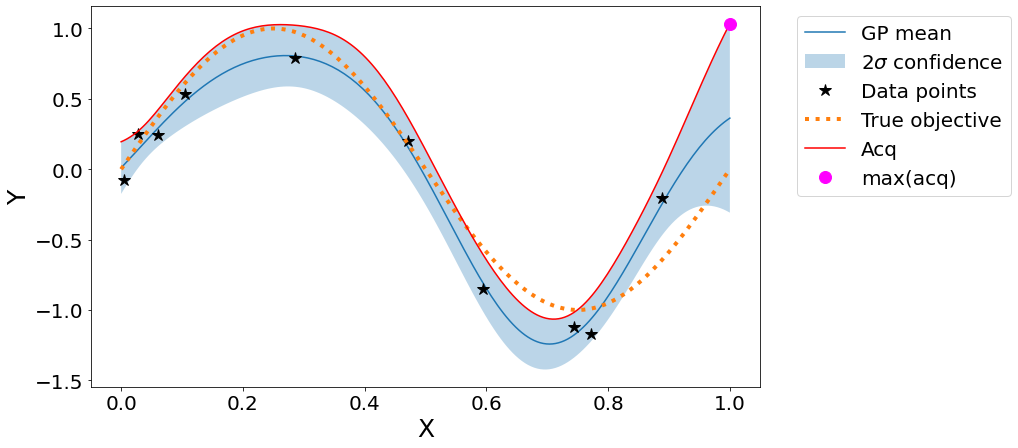

In [134]:
acq_UCB = UpperConfidenceBound(model, beta=4)
plot_acq_with_gp(model, observations_x, observations_y, acq_UCB, test_X, show_true_f=True, 
                 true_f_x= objective_x, true_f_y=objective_y)

<h3 style="color:#e6541a;">Try other acquisition functions</h3>
<p style="color:#e6541a;">$\implies$ Try expected improvement and probability of improvement by executing the cells below</p>

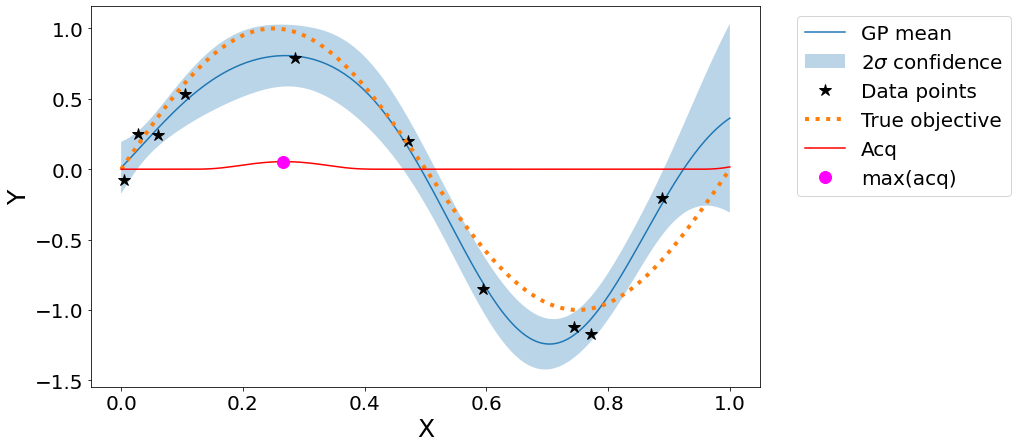

In [135]:
acq_EI = ExpectedImprovement(model,best_f=float(model.train_targets.max()))
plot_acq_with_gp(model, observations_x, observations_y, acq_EI, test_X, show_true_f=True, 
                 true_f_x= objective_x, true_f_y=objective_y)

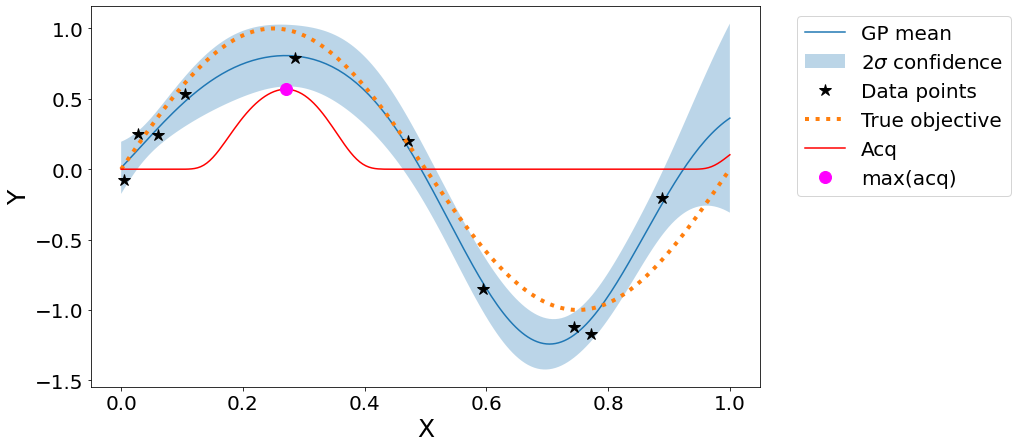

In [136]:
acq_PI = ProbabilityOfImprovement(model, best_f=float(model.train_targets.max()))
plot_acq_with_gp(model, observations_x, observations_y, acq_PI, test_X, show_true_f=True, 
                 true_f_x= objective_x, true_f_y=objective_y)

<h3 style="color:#e6541a;">What are the different sampling strategies of different acquisition functions?</h3>
<p style="color:#e6541a;">$\implies$ Which one is closer to finding the global maximum?</p>

<h2>Bonus: Bayesian exploration</h2>

- Instead of doing optimization, we can tweak the acquisition function to only learn about the objective function
- For example, instead of using $\mu(x) + \sqrt{\beta}\sigma(x)$ as in UCB, we can choose the acquisition to be $\alpha(x)= \sigma(x)$. 
    - In this way, we will only sample the function where the uncertainty is large.



<div style="text-align: center; width:100%;">
    <h2>Part III: Bayesian Optimization for Beam Positioning and Focusing in a Linac</h2>
</div>

<h2 style="text-align: center; vertical-align: middle;">Beam positioning and focusing task at ARES Experimental Area (EA)</h2> 

We would like to focus and center the electron beam on a diagnostic screen using 2 corrector and 3 quadrupole magnets.

![ARES EA Scheme](img/ares_magnets.png)

<h2>Look at the ARESEA environment</h2>

We formulated the ARESEA task as a [OpenAI Gym](https://github.com/openai/gym) environment, which is a common approach for Reinforcement learning projects. This allows our algorithm to easily interface with both the simulation and real machine backends.

In this part, you will get familiar with the environment for the beam focusing and positioning at ARES accelerator.

First, let's create the environment.

In [24]:
# Create the environment
env = ARESEA()

# Wrap the environment with some utilities:
env = RescaleAction(env, -1, 1)  # Normalize the action space to [-1,1]^n
env.reset()

({'magnets': array([0., 0., 0., 0., 0.]),
  'target_beam': array([-0.00063545,  0.00067332,  0.00088127,  0.00078832], dtype=float32),
  'current_beam': array([0.        , 0.00010026, 0.        , 0.00010026], dtype=float32)},
 {})

<h3 style="color:#e6541a;">Get familiar with the Gym environment</h3>
<p style="color:#e6541a;">$\implies$ Change the magnet values, i.e. the actions</p>
<p style="color:#e6541a;">$\implies$ The actions are normalized to 1, so valid values are in the [0, 1] interval</p>
<p style="color:#e6541a;">$\implies$ The values of the <code>action</code> list in the cell below follows this magnet order: [Q1, Q2, CV, Q3, CH]</p>
<p style="color:#e6541a;">$\implies$ Observe the plot below, what beam does that magnet configuration yield? can you center and focus the beam by hand?</p>

In [154]:
action = np.array([1, 0.5, 0.5, 1, 0.6])  # put your action here

Perform one step: update the env, observe new beam!

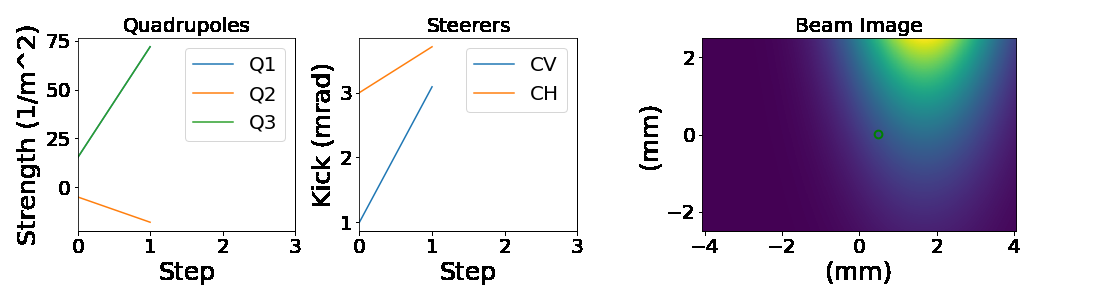

In [155]:
env.reset()
observation, reward, done, info = env.step(action)

fig = plt.figure()
fig.set_size_inches(16, 4)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)
img = env.render(mode="rgb_array")

ax.imshow(img)

<h3 style="color:#e6541a;">Take several steps in the environment</h3>
<p style="color:#e6541a;">$\implies$ Run the cell below, which will perform a linear scan of the values corresponding to the horizontal corrector CH</p>
<p style="color:#e6541a;">$\implies$ What influence does CH have on the beam?</p>

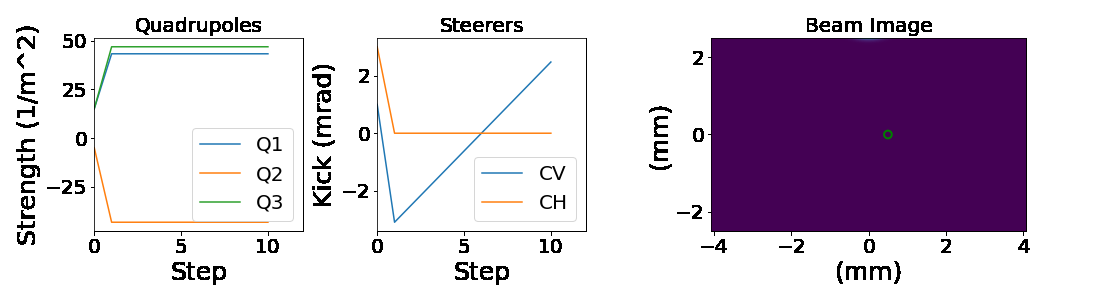

In [152]:
env.reset()
steps = 10

for i in range(steps):
    env.step(np.array([0.2, -0.2, -.5 + 1 / steps * i, 0.3, 0]))
    img = env.render(mode="rgb_array")
    ax.imshow(img)
    display(fig)
    clear_output(wait=True)
    time.sleep(0.5)

<h3 style="color:#e6541a;">Set a target beam you want to achieve</h3>
<p style="color:#e6541a;">$\implies$ Let's define the position $(\mu_x, \mu_y)$ and size $(\sigma_x, \sigma_y)$ of the beam on the screen</p>
<p style="color:#e6541a;">$\implies$ Modify the <code>target_beam</code> list below, where the order of the arguments is $[\mu_x,\sigma_x,\mu_y,\sigma_y]$</p>
<p style="color:#e6541a;">$\implies$ Take into account the dimensions of the screen ($\pm$ 2e-3 m)</p>
<p style="color:#e6541a;">$\implies$ The target beam will be represented by a green circle on the screen</p>

In [159]:
target_beam = [1e-3, 1e-4, 0, 1e-4]  # Change it

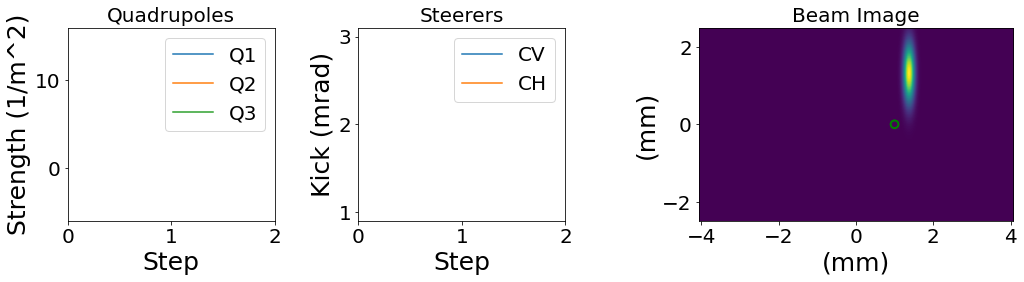

In [160]:
env = ARESEA(target_beam_mode="constant",target_beam_values=target_beam, 
             magnet_init_mode="constant", magnet_init_values=[15, -5, 1e-3, 15, 3e-3])
env = RescaleAction(env, -1, 1)  # Normalize the action space to [-1,1]^n
observation, _ = env.reset()
env.render()

<h2>Implementation of a full Bayesian optimization loop</h2>

In [153]:
def bayesian_optimize(env: gym.Env, last_observation, init_mode="current", n_steps=50, 
                      acquisition="UCB", beta=2, n_init=3, max_step_size:float=0.5, set_to_best=True, 
                      random_seed=None, show_plot=False, proximal=None,time_sleep=0.2):
    ##################################################################
    # Some preliminary settings
    if random_seed is None:
        random_seed = torch.random.seed() # random
    rng = torch.random.manual_seed(random_seed)

    # Initialization: some initial samples are needed to build a GP model

    # First sample from the reset observation
    initial_action = scale_action(env, last_observation)

    if init_mode=="current":
        X = torch.tensor([initial_action]).reshape(1,-1)
        while len(X)<n_init:
            last_action = X[0].detach().numpy()
            bounds = get_new_bound(env, last_action, max_step_size)
            new_action = np.random.uniform(low=bounds[0], high=bounds[1])
            new_action_tensor = torch.tensor(new_action, dtype=torch.double).reshape(
                1, -1
            )
            X = torch.cat([X,new_action_tensor])
    else:  # sample purely randomly
        X = torch.tensor([], dtype=torch.double)
        while len(X)<n_init:
            new_action = env.action_space.sample()
            new_action_tensor = torch.tensor(new_action, dtype=torch.double).reshape(
                1, -1
            )
            X = torch.cat([X,new_action_tensor])
    
    Y = torch.zeros(n_init,1,dtype=torch.double)
    # sample initial points
    for i,x in enumerate(X):  
        _, reward, _, _ = env.step(x.numpy())
        Y[i] = reward

    if show_plot:
        fig = plt.figure()
        fig.set_size_inches(16,4)
        ax_progress = plt.Axes(fig, [0.0, 0.0, 0.25, 1.0])
        ax = plt.Axes(fig, [0.25, 0.0, 1.0, 1.0])
        ax.set_axis_off()
        fig.add_axes(ax_progress)
        fig.add_axes(ax)
        ax_progress.set_xlabel("Steps")
        ax_progress.set_ylabel(r"log(MAE($b_\mathrm{current}, b_\mathrm{target}$))")
        ax_progress.set_title(f"Best objective: {float(Y.max())}")
    
    ##################################################################
    # Actual BO logic
    for i in range(n_steps):
        # Fit GP model to the observed data
        kernel=ScaleKernel(MaternKernel())
        model = SingleTaskGP(X, Y,covar_module=kernel,outcome_transform=Standardize(m=1))
        # model.likelihood.noise = 1e-2
        # model.likelihood.noise_covar.raw_noise.requires_grad_(False)
        mll = ExactMarginalLogLikelihood(model.likelihood,model)
        fit_gpytorch_mll(mll)
        
        # Build acquisition
        if acquisition=="UCB":
            acq = UpperConfidenceBound(model, beta=beta)
        elif acquisition=="EI":
            ymax = float(Y.max())
            acq = ExpectedImprovement(model, best_f=ymax)
        
        if proximal is not None:
            acq = ProximalAcquisitionFunction(acq,proximal_weights=proximal)

        # Choose next action
        new_bound = get_new_bound(env,X[-1].detach().numpy(),max_step_size)
        x_next, _ = optimize_acqf(acq, bounds=torch.tensor(new_bound),q=1,num_restarts=16,raw_samples=256,options={"maxiter": 200},) 
        # Apply the action
        observation, reward, done, _ = env.step(x_next.numpy().flatten())
        
        # Append data (with correct shape)
        Y = torch.cat([Y,torch.tensor([[reward]])])
        X = torch.cat([X,torch.tensor(x_next).reshape(1,-1)])
        

        # Plotting
        if show_plot:
            img = env.render(mode="rgb_array")
            ax.imshow(img)
            ax_progress.clear()
            ax_progress.plot(Y.detach().numpy().flatten())
            ax_progress.set_title(f"Best objective: {float(Y.max()):.2f}")
            ax_progress.set_xlabel("Steps")
            ax_progress.set_ylabel(r"log(MAE($b_\mathrm{current}, b_\mathrm{target}$))")
            display(fig)
            clear_output(wait=True)
            time.sleep(time_sleep)

        # Check termination
        if done:
            print("Target beam is reached")
            set_to_best=False  # no need to reset
            break
    # Set to best observed if not reaching target in the allowed steps
    if set_to_best:
        x_best = X[Y.flatten().argmax()].numpy()
        env.step(x_best)
        # Plotting
        if show_plot:
#             print(f"Best objective: {float(Y.max())}")
            img = env.render(mode="rgb_array")
            ax.imshow(img)
            display(fig)
            clear_output(wait=True)
            time.sleep(time_sleep)

    # Return some information
    opt_info = {
        "X": X,
        "Y": Y,
        "best": Y.max(),
    }
    return opt_info



<h2>Let's apply Bayesian optimization to this problem</h2>

- We will use the loop implemented in the cell above
- In order to quantify how the algorithm is performing, we will use the __log maximum aboslute error (L1 error)__ as metric:

$$\begin{aligned}
f(x) &= -\log(\mathrm{MAE}(b_\mathrm{current},b_\mathrm{target})) \\
&= - \log \sum_i |b_{\mathrm{current},i}-b_{\mathrm{target},i}| 
\end{aligned}$$

- We do this because using just the difference between the target and the real beam is very small (sub mm)

<h3 style="color:#e6541a;">Running Bayesian optimization</h3>
<p style="color:#e6541a;">$\implies$ Run the cell below and observe the optimization. Did it achieve the target? How did the performance metric evolve during the optimization?</p>
<p style="color:#e6541a;">$\implies$ Change the <code>max_step_size</code> argument. This indicates how much each action changes per step. What do you observe if the steps are too large?</p>
<p style="color:#e6541a;">$\implies$ Do you think that adding more iteration steps will help?</p>
<p style="color:#e6541a;">$\implies$ Can you think of other ways of solving this focusing and steering problem automatically?</p>

KeyboardInterrupt: 

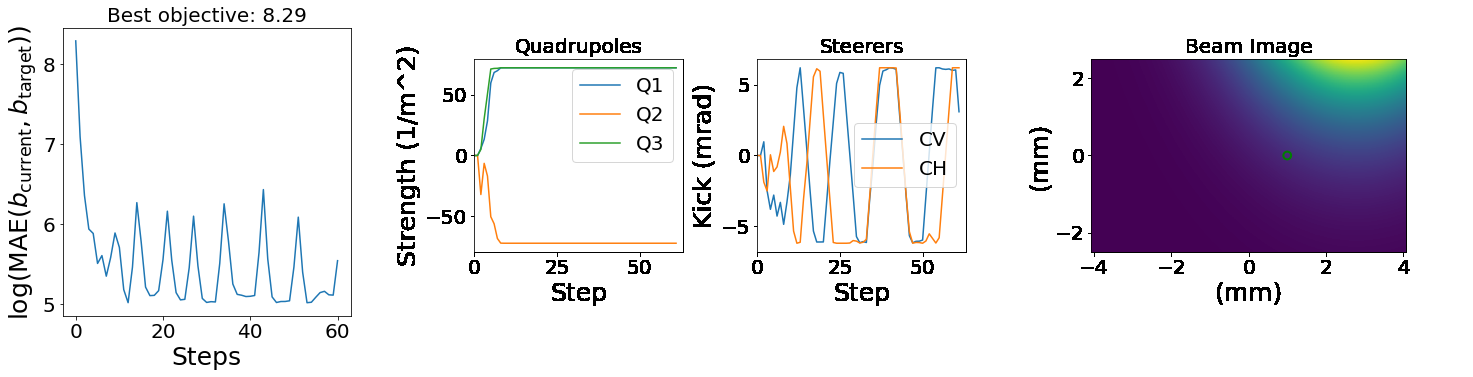

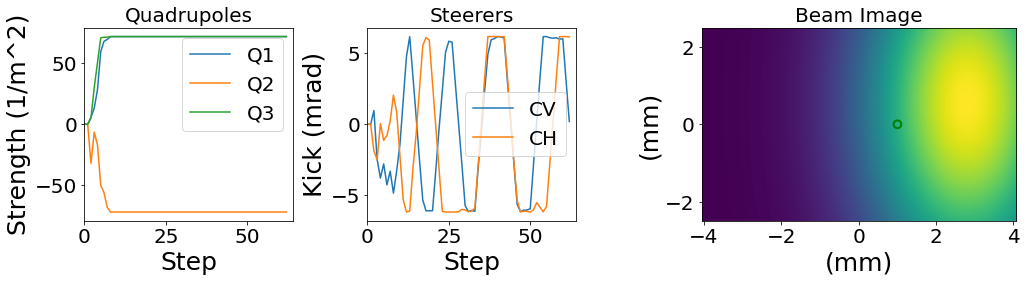

In [168]:
env = ARESEA(target_beam_mode="constant",target_beam_values=target_beam, magnet_init_mode="random")
observation, _ = env.reset()
# Here we use the trick to contrain allowed action step size
opt_info = bayesian_optimize(env, last_observation=observation, n_steps=100, max_step_size=0.5,  
                             show_plot=True, beta=0.2, time_sleep=0.05)
# Another advanced technique "Proximal biasing" uses soft step size limit
# opt_info = bayesian_optimize(env, last_observation=observation,n_steps=50,max_step_size=1,  
# show_plot=True, beta=0.2, proximal=torch.ones(5)*0.5)

<h3 style="color:#e6541a;">Exploration and exploitation with acquisition functions</h3>
<p style="color:#e6541a;">$\implies$ Change the <code>beta</code> argument of the <code>bayesian_optimize</code> function in the cell below to 2. What is different in this optimization compared to the previous one? How does the performance metric evolve?</p>
<p style="color:#e6541a;">$\implies$ Use a different acquisition function, like expected improvement "EI"</p>

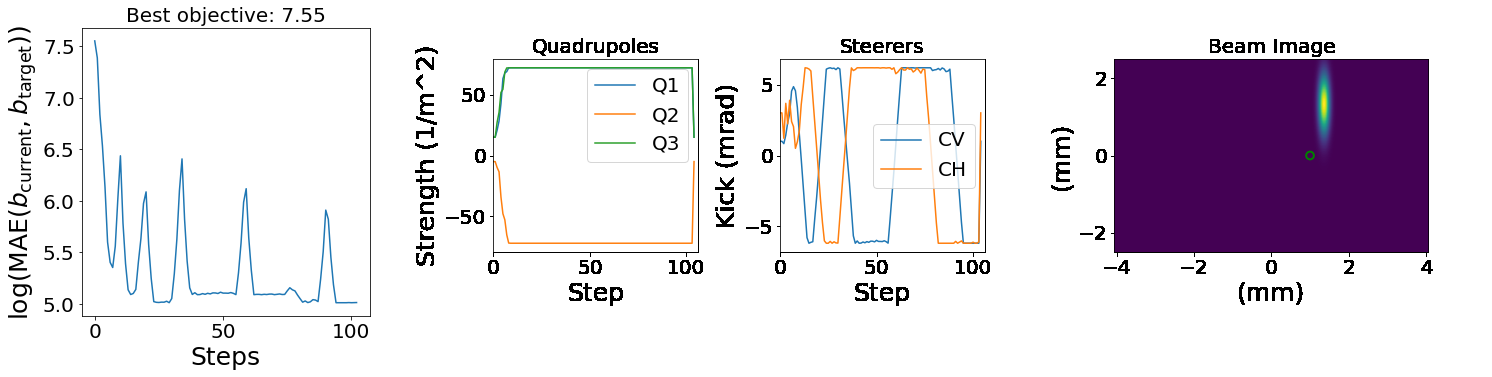

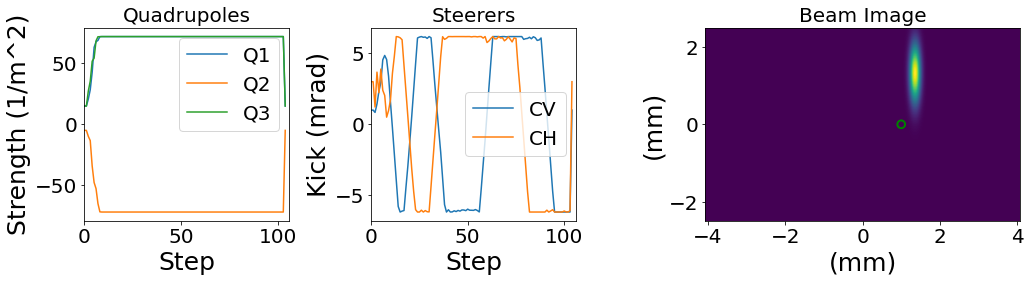

In [165]:
### Initialize the environment
env = ARESEA(target_beam_mode="constant",target_beam_values=target_beam, magnet_init_mode="random")
observation, _ = env.reset()


### Change the value of beta, see how it impacts the optimization process; 
### Or switch to another acquisition
opt_info = bayesian_optimize(env, observation, n_steps=100, acquisition="UCB", beta=2.0,
                             max_step_size=0.3, show_plot=True, time_sleep=0.05)  


## Summary

- Bayesian Optimization is a numerical _global_ optimization method for black-box functions.

- BO uses a _Gaussian process_ as a statistical surrogate model of the objective.
  - GP is characterized by its mean and covariance (kernel) function.
  - Hyperparamters can be dynamically fitted to the data.
  - Prior knowledge can be included for setting the priors.
- BO uses the _acquisition function_ to guide the optimziation
  - One should choose an acquisition suitable for the task.
  - Hyperparameters of the acquisition function also affects the optimization behaviour.
- BO is an __optimization__ method. It is not designed for a _control_ task.
- It is adequate for a moderate amount of dimensions (~100)

## Literature

Hopefully you have learned something about BO, if you want to try it yourself afterwards, below are some interesting resources.

### Publication: Various applications of BO in accelerator physics

- KARA, KIT: [Bayesian Optimization of the Beam Injection Process into a Storage Ring](https://arxiv.org/abs/2211.09504) Beam injection optimization using BO.
- LCLS, SLAC: [Bayesian optimization of FEL performance at LCLS](https://accelconf.web.cern.ch/ipac2016/doi/JACoW-IPAC2016-WEPOW055.html), [Bayesian Optimization of a Free-Electron Laser](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.124801) FEL performance tuning with quadrupoles
- LUX, DESY: [Bayesian Optimization of a Laser-Plasma Accelerator](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.104801) LPA tuning to improve bunch quality with laser energy, focus position, and gas flows.
- Central Laser Facility, Rutherfold UK: [Automation and control of laser wakefield accelerators using Bayesian optimization](https://www.nature.com/articles/s41467-020-20245-6), LWFA performance tuning with different objective functions
- PSI, SwissFEL: [Tuning particle accelerators with safety constraints using Bayesian optimization](https://doi.org/10.1103/PhysRevAccelBeams.25.062802) [Adaptive and Safe Bayesian Optimization in High Dimensions via One-Dimensional Subspaces](https://arxiv.org/abs/1902.03229) : BO with safety contraints to protect the machine
- SLAC, ANL: [Multiobjective Bayesian optimization for online accelerator tuning](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.062801), multiobjective optimization for accelerator tuning,[Turn-key constrained parameter space exploration for particle accelerators using Bayesian active learning](https://www.nature.com/articles/s41467-021-25757-3), Bayesian active learning for effcient exploration of the parameter space. [Differentiable Preisach Modeling for Characterization and Optimization of Particle Accelerator Systems with Hysteresis](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.128.204801) hysteris modelling with GP, and application of hysteresis-aware BO.

### Books and papers on Bayesian optimization in general

- C. E. Rasmussen and C. K.I. Williams, [Gaussian Processes for Machine Learning](https://gaussianprocess.org/gpml/): __the__ classic textbook of Gaussian process.
- Eric Brochu, [A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning](https://arxiv.org/abs/1012.2599): a comprehensive tutorial on Bayesian optimization with some application cases at that time (2010).
- Peter I. Frazier, [A Tutorial on Bayesian Optimization](https://arxiv.org/abs/1807.02811): a more recent (2018) tutorial paper covering the most important aspects of BO, and some advanced variants of BO (parallel, multi-fidelity, multi-task).

### Bayesian Optimization / Gaussian Process packages in python

Below is a incomplete selection of python packages for BO and GP, each with its own strength and drawback.

- [scikit-learn Gaussian processes](https://scikit-learn.org/stable/modules/gaussian_process.html#) : recommended for sklearn users, not as powerful as other packages.
- [GPyTorch](https://gpytorch.ai/) : a rather new package implemented natively in PyTorch, which makes it very performant. Also comes with a Bayesian optimization package [BOTorch](https://botorch.org/), offering a variety of different optimization methods (mult-objective, parallelization...). Both packages are being actively developed maintained; __recommended state-of-the-art tool for BO practitioners__.
- [GPflow](https://www.gpflow.org/) : a GP package implemented in TensorFlow, it also has a large community and is being actively maintained; The new BO package [Trieste](https://secondmind-labs.github.io/trieste) is built on it.
- [GPy](http://sheffieldml.github.io/GPy/) from the Sheffield ML group : A common/classic choice for building GP model, includes a lot of advanced GP variants; However in recent years it is not so actively maintained. It comes with the accompanying Bayesian optimization package [GPyOpt](https://github.com/SheffieldML/GPyOpt), for which the maintainance stoped since 2020.
- [Dragonfly] : a open-source BO package; offers also command line tool, easy to use if you are a practitioner. However if one has less freedom to adapt and expand the code.

C.f. the [wikipedia page](https://en.wikipedia.org/wiki/Comparison_of_Gaussian_process_software#Comparison_table) for a more inclusive table with GP packages for other languages.

### Other Resources

- Another similarly structured BO tutorial using the _scikit-learn_ GP package, given at the [2022 MT ARD ST3 ML Workshop](https://github.com/ansantam/2022-MT-ARD-ST3-ML-workshop)